In [8]:
# Imports
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Training libs
from sklearn.ensemble import IsolationForest

# Data Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [9]:
# Feature groups
anomaly_detection_input_features = [
    # Non-feature columns
    "id",             # Unique identifier for the transaction (dropped in training)
    "date",                       # (String) Transaction date (YYYY-MM-DD HH:MM:SS)

    # Feature columns
    "amount",                     # (Float) Transaction amount
    "merchant_city",                   # (String) City or ZIP code of transaction location
    "hour_of_day",                # (Integer) Hour of day (0-23)
    "day_of_week",                # (Integer) Day of week (0=Mon ... 6=Sun)"
    "mcc",                        # (String) ID of the merchant
]

In [10]:
# Load the dataset with date parsing
train_dataset_file_path = "assets/chatgpt_data/transactions_o3_2_test.csv"
df = pd.read_csv(train_dataset_file_path, parse_dates=['date'])

In [11]:
# Preprocess features (since this data was generated by gpt, we can assume it is clean)
def preprocess(v_df: pd.DataFrame) -> pd.DataFrame:
    #* Sort Data
    v_df = v_df.sort_values(["date"])

    # If hour_of_day or day_of_week is not present, create them
    if "hour_of_day" not in v_df.columns:
        v_df["hour_of_day"] = v_df["date"].dt.hour
    if "day_of_week" not in v_df.columns:
        v_df["day_of_week"] = v_df["date"].dt.dayofweek

    # Convert credit/debit to binary
    if "transaction_type" in v_df.columns:
        v_df["transaction_type"] = v_df["transaction_type"].map({"credit": 1, "debit": 0})

    # Convert any boolean columns to 0/1
    bool_cols = v_df.select_dtypes(include="bool").columns
    for c in bool_cols:
        v_df[c] = v_df[c].astype(int)

    return v_df

In [12]:
def under_sample_majority_class(df: pd.DataFrame) -> pd.DataFrame:
    df_fraud = df[df['target'] == 1]
    df_no_fraud = df[df['target'] == 0]
    df_no_fraud_sampled = df_no_fraud.sample(n=len(df_fraud), random_state=42)
    df_balanced = pd.concat([df_fraud, df_no_fraud_sampled], axis=0)
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    return df_balanced

In [13]:
# Final Cleanup
df = preprocess(df)

final_features = [c for c in anomaly_detection_input_features if c in df.columns]
df = df[final_features]

In [14]:
# Convert categorical features to numerical
# Drop non-features
cols_to_drop = ["id", "date"]
df = df.drop(columns=cols_to_drop)


In [15]:
iso_params = {
    "n_estimators": 200,
    "max_samples": "auto",
    # "max_features": 1.0,
    # "bootstrap": True,
    "contamination": 0.011,
    "n_jobs": -1,
    "random_state": 42,
    "verbose": 0,
}

In [16]:
cat_cols  = ["merchant_city", "mcc"] 
num_cols  = ["amount", "hour_of_day", "day_of_week"]

pre = ColumnTransformer(
        [
            ("cat", OneHotEncoder(handle_unknown="ignore", dtype=np.int8), cat_cols), 
            ("num", StandardScaler(), num_cols)
        ], 
        sparse_threshold=0.3  # keeps output sparse if >70 % zeros
)  

model = Pipeline([
        ("pre", pre),
        ("iso", IsolationForest(**iso_params)),
])

model.fit(df)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(dtype=<class 'numpy.int8'>,
                                                                handle_unknown='ignore'),
                                                  ['merchant_city', 'mcc']),
                                                 ('num', StandardScaler(),
                                                  ['amount', 'hour_of_day',
                                                   'day_of_week'])])),
                ('iso',
                 IsolationForest(contamination=0.011, n_estimators=200,
                                 n_jobs=-1, random_state=42))])

/var/folders/gd/d2vxxv2x60j28jw85n3wg5dw0000gn/T/ipykernel_84068/3675248980.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"target": {"Yes": 1, "No": 0}})


Accuracy : 0.9983949456660672
Precision: 0.12795125666412796
Recall   : 0.012601260126012601
F1       : 0.02294298395356777


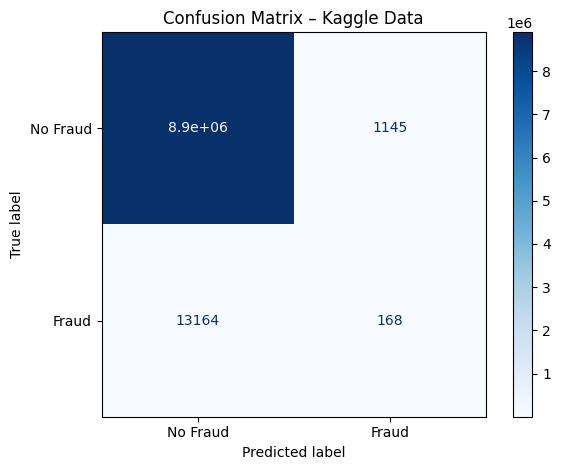

In [18]:
# 1.  LOAD & PREPARE THE SECOND / KAGGLE DATA SET
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

def prepare_tx_dataset(tx_path, labels_path=None):
    """
    Load a transactions CSV (and optional labels JSON) and add simple
    date-derived features.  No 'cards' file involved.
    """
    tx = pd.read_csv(
            tx_path,
            usecols=["id", "date", "amount", "merchant_city", "mcc"]
         )

    tx["date"]   = pd.to_datetime(tx["date"])
    tx["amount"] = tx["amount"].str.lstrip("$").astype(float)

    # Derive extra features
    tx["hour_of_day"] = tx["date"].dt.hour
    tx["day_of_week"] = tx["date"].dt.weekday

    if labels_path is not None:
        labels = (
            pd.read_json(labels_path)
              .reset_index()
              .rename(columns={"index": "id"})
              .replace({"target": {"Yes": 1, "No": 0}})
        )
        tx = tx.merge(labels, on="id")

    return tx


# Load the Kaggle data
tx_file      = "assets/kaggle_data/transactions_data.csv"
labels_file  = "assets/kaggle_data/train_fraud_labels.json"

# Prepare the dataset
kag_df = prepare_tx_dataset(tx_file, labels_file)

has_labels = "target" in kag_df.columns
if has_labels:
    y_kag = kag_df["target"]

X_kag = kag_df.drop(columns=["id", "date"] + (["target"] if has_labels else []))


# 2. PREDICT ANOMALIES
kag_pred = np.where(model.predict(X_kag) == -1, 1, 0)

# 3. METRICS + CONFUSION MATRIX
if has_labels:
    print("Accuracy :",  accuracy_score(y_kag, kag_pred))
    print("Precision:",  precision_score(y_kag, kag_pred, zero_division=0))
    print("Recall   :",  recall_score(y_kag, kag_pred))
    print("F1       :",  f1_score(y_kag, kag_pred))

    cm   = confusion_matrix(y_kag, kag_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Fraud", "Fraud"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix – Kaggle Data")
    plt.tight_layout()
    plt.show()
else:
    print("Predictions generated (no ground-truth labels supplied).")
